# Removing Spikes from Raman Spectra: A Step-by-Step Guide with Python

This tutorial is part of a growing series on Data Science for Raman Spectroscopy with Python published in my GitHub account and towardsdatascience.com. By following along, you’ll add a valuable tool to your data analysis toolkit—an effective method for cleaning up Raman spectra that’s already used in published research. 

This notebook is based on **"An intuitive approach for spike removal in Raman spectra based on peaks’ prominence and width"**, by N. Coca-Lopez, published in Analytica Chimica Acta, Volume 1295, 2024, 342312. (https://doi.org/10.1016/j.aca.2024.342312).

## Introduction

Spike removal is an essential part of Raman data preprocessing. Spikes, caused by cosmic rays impacting the detector, appear as intense, narrow peaks that can distort the analysis. These bursts of energy hit the charge-coupled device (CCD) camera, creating sharp, high-intensity peaks that, if left uncorrected, can interfere with further processing steps like normalization, spectral search, or multivariate data analysis. Cleaning these artifacts is therefore a priority. In this tutorial, we’ll cover a practical algorithm for removing spikes from Raman spectra. Using Python, we'll walk through a user-friendly, customizable approach for spike detection and correction to keep Raman data accurate and reliable.

Figure 1 shows an example graphene Raman spectrum where a spike is present. Graphene’s exceptional physical properties—such as its electrical and thermal conductivity—have made it a highly studied material. Its Raman spectrum contains peaks that reflect structural characteristics, revealing information about doping, strain, and grain boundaries. Therefore, Raman spectroscopy is a widely used technique to characterize graphene. However, to make most of these tool, spikes must be previously removed.


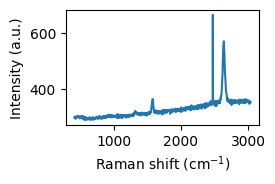

In [9]:
import numpy as np
# Load data directly into a numpy array
data = np.loadtxt(file_0, delimiter=',', skiprows=1)

# Extract wavelength from the first column (index)
ramanshift = data[:, 0]

# Extract intensity from the third column (index 2 in Python)
intensity = data[:, 3]

# Plot the data
import matplotlib.pyplot as plt
#fig = plt.figure(figsize = (5,3))

fig = plt.figure(figsize = (2.5,1.5))
plt.plot(ramanshift, intensity)
plt.xlabel('Raman shift (cm$^{-1}$)')
plt.ylabel('Intensity (a.u.)')
plt.savefig('graphene spectrum spike.jpg', format='jpg', dpi=600, bbox_inches='tight')
plt.show()

## The spike removal algorithm

The spike removal algorithm presented here consists in four main steps: <br>

**1. Peak finding**<br>
**2. Spike detection**<br>
**3. Spike flagging**<br>
**4. Spectrum correction**<br>

Let's take a look at the different steps with Python code snippets:

**1. Peak finding:** First, the algorithm identifies significant peaks by checking for local maxima with a minimum prominence threshold. Adding a prominence threshold helps to exclude small noise-generated peaks, as we don't aim to correct all the noise. See the following figure for comparison.

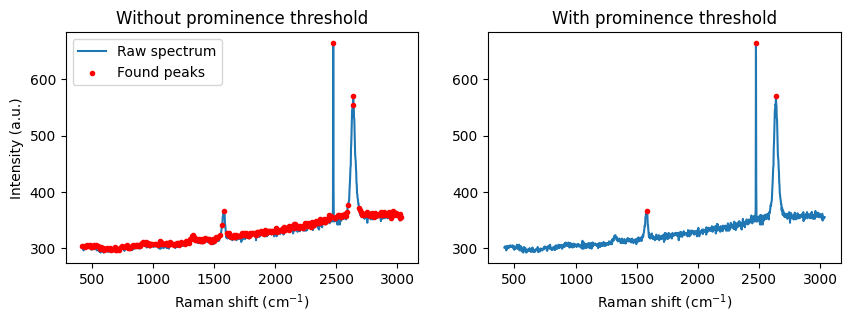

In [2]:
from scipy.signal import find_peaks
peaks_wo_p, _ = find_peaks(intensity) # Peaks found without a prominence threshold
peaks_w_p, _ = find_peaks(intensity, prominence = 20) # Peaks found without a prominence threshold

fig, ax = plt.subplots(1, 2, figsize = (2*5,3))
ax[0].plot(ramanshift, intensity, zorder=0, label='Raw spectrum')
ax[0].scatter(ramanshift[peaks_wo_p], intensity[peaks_wo_p], marker ='.', color = 'red',label='Found peaks')
ax[1].plot(ramanshift, intensity, zorder=0, label='Raw spectrum')
ax[1].scatter(ramanshift[peaks_w_p], intensity[peaks_w_p], marker ='.', color = 'red',label='Found peaks')
ax[0].set_title('Without prominence threshold')
ax[1].set_title('With prominence threshold')
ax[0].set_xlabel('Raman shift (cm$^{-1}$)')
ax[1].set_xlabel('Raman shift (cm$^{-1}$)')
ax[0].set_ylabel('Intensity (a.u.)')
plt.savefig('step 1 - find peaks.jpg', format='jpg', dpi=600, bbox_inches='tight')
ax[0].legend()
plt.show()

**2. Spike detection** Then, spikes are flagged based on their characteristic narrow widths. This point might help on the automation of large spectral datasets. If we know the width of the Raman bands present in our spectra, we can choose a threshold below such value. For example, with our system resolution we do not expect to have graphene Raman bands with widths below 10 cm$^{-1}$.

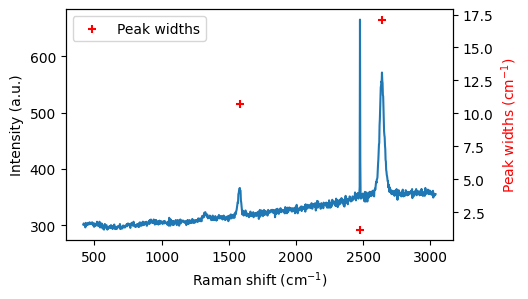

In [3]:
from scipy.signal import peak_widths
widths = peak_widths(intensity, peaks_w_p)[0]

fig, ax = plt.subplots(figsize = (5,3))
ax.plot(ramanshift, intensity, zorder=0, label='Raw spectrum')
ax.set_xlabel('Raman shift (cm$^{-1}$)')
ax.set_ylabel('Intensity (a.u.)')
ax2 = ax.twinx()
ax2.scatter(ramanshift[peaks_w_p], widths, marker ='+', color = 'red',label='Peak widths')
ax2.set_ylabel('Peak widths (cm$^{-1}$)', color ='red')
ax2.legend()
plt.savefig('step 2 - find widths.jpg', format='jpg', dpi=600, bbox_inches='tight')
plt.show()

**3. Spike flagging** Next, any data points affected by spikes are flagged using a range calculated from the peak’s prominence, effectively isolating corrupted pixels. In other words, we select the window that must be corrected

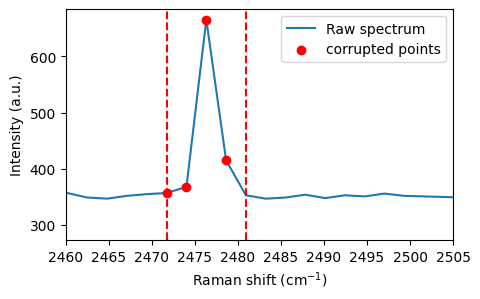

In [4]:
# Let's set the parameters:
width_param_rel = 0.8
width_threshold = 10 # Estimation of the width of the narrowest Raman band

# Calculation of the range where the spectral points are asumed to be corrupted
widths_ext_a = peak_widths(intensity, peaks_w_p, rel_height=width_param_rel)[2]
widths_ext_b = peak_widths(intensity, peaks_w_p, rel_height=width_param_rel)[3]

# Create a vector where spikes will be flag: no spike = 0, spike = 1.
spikes = np.zeros(len(intensity))
    
# Flagging the area previously defined if the peak is considered a spike (width below width_threshold)
for a, width, ext_a, ext_b in zip(range(len(widths)), widths, widths_ext_a, widths_ext_b):
    if width < width_threshold:
        spikes[int(ext_a) - 1: int(ext_b) + 2] = 1 

fig = plt.figure(figsize = (5,3))
plt.plot(ramanshift, intensity, zorder=0,label='Raw spectrum')
a=1
plt.scatter(ramanshift[int(widths_ext_a[a])-1 : int(widths_ext_b[a])+1], 
            intensity[int(widths_ext_a[a])-1 : int(widths_ext_b[a])+1], 
            color ='red', label = 'corrupted points')
plt.axvline(x = ramanshift[int(widths_ext_a[a]) -1], linestyle = '--', color = 'red')
plt.axvline(x = ramanshift[int(widths_ext_b[a]) + 1], linestyle = '--', color = 'red')  
plt.xlim(2460,2505)
plt.xlabel('Raman shift (cm$^{-1}$)')
plt.ylabel('Intensity (a.u.)')
plt.legend()
plt.savefig('step 3 - flagging.jpg', format='jpg', dpi=600, bbox_inches='tight')

**4. Spectrum correction** Finally, these points are corrected through interpolation of nearby values, preserving the spectrum's integrity for subsequent analyses.


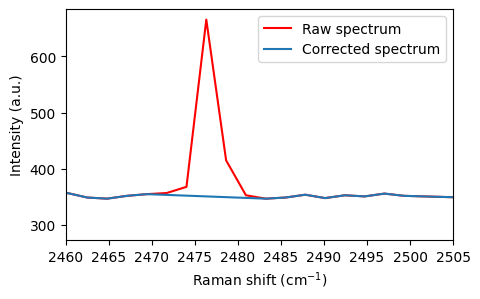

In [5]:
from scipy import interpolate
# Let's set the parameter:
moving_average_window = 10

intensity_out = intensity.copy()
    
# Interpolation of corrupted points
for i, spike in enumerate(spikes):
    if spike != 0: # If we have an spike in position i
        window = np.arange(i - moving_average_window, i + moving_average_window + 1) # we select 2 ma + 1 points around our spike
        window_exclude_spikes = window[spikes[window] == 0] # From such interval, we choose the ones which are not spikes
        interpolator = interpolate.interp1d(window_exclude_spikes, intensity[window_exclude_spikes], kind='linear') # We use the not corrupted points around the spike to calculate the interpolation
        intensity_out[i] = interpolator(i) # The corrupted point is exchanged by the interpolated value.

fig = plt.figure(figsize = (5,3))
plt.plot(ramanshift, intensity, zorder=0, color ='red',label='Raw spectrum')
plt.plot(ramanshift, intensity_out, zorder=0, label='Corrected spectrum')
plt.xlim(2460,2505)
plt.legend()
plt.xlabel('Raman shift (cm$^{-1}$)')
plt.ylabel('Intensity (a.u.)')
plt.savefig('step 4 - correction.jpg', format='jpg', dpi=600, bbox_inches='tight')
plt.show()


# A spike removal function

All these snippets can be summarize in a single function to help fixing our spectra. This function is designed to be customizable based on your specific data needs, with parameters for adjusting prominence and width:

In [7]:
import numpy as np
from scipy.signal import find_peaks, peak_widths, peak_prominences
from scipy import interpolate

def spike_removal(y, 
                  width_threshold, 
                  prominence_threshold=None, 
                  moving_average_window=10, 
                  width_param_rel=0.8, 
                  interp_type='linear'):
    """
    Detects and replaces spikes in the input spectrum with interpolated values. Algorithm first 
    published by N. Coca-Lopez in Analytica Chimica Acta. https://doi.org/10.1016/j.aca.2024.342312

    Parameters:
    y (numpy.ndarray): Input spectrum intensity.
    width_threshold (float): Threshold for peak width.
    prominence_threshold (float): Threshold for peak prominence.
    moving_average_window (int): Number of points in moving average window.
    width_param_rel (float): Relative height parameter for peak width.
    tipo: type of interpolation (linear, quadratic, cubic)
    
    Returns:
    numpy.ndarray: Signal with spikes replaced by interpolated values.
    """

    # First, we find all peaks showing a prominence above prominence_threshold on the spectra
    peaks, _ = find_peaks(y, prominence=prominence_threshold)
    
    # Create a vector where spikes will be flag: no spike = 0, spike = 1.
    spikes = np.zeros(len(y))
    
    # Calculation of the widths of the found peaks
    widths = peak_widths(y, peaks)[0]
    
    # Calculation of the range where the spectral points are asumed to be corrupted
    widths_ext_a = peak_widths(y, peaks, rel_height=width_param_rel)[2]
    widths_ext_b = peak_widths(y, peaks, rel_height=width_param_rel)[3]
    
    # Flagging the area previously defined if the peak is considered a spike (width below width_threshold)
    for a, width, ext_a, ext_b in zip(range(len(widths)), widths, widths_ext_a, widths_ext_b):
        if width < width_threshold:
            spikes[int(ext_a) - 1: int(ext_b) + 2] = 1 
            
    y_out = y.copy()
    
    # Interpolation of corrupted points
    for i, spike in enumerate(spikes):
        if spike != 0: # If we have an spike in position i
            window = np.arange(i - moving_average_window, i + moving_average_window + 1) # we select 2 ma + 1 points around our spike
            window_exclude_spikes = window[spikes[window] == 0] # From such interval, we choose the ones which are not spikes
            interpolator = interpolate.interp1d(window_exclude_spikes, y[window_exclude_spikes], kind=interp_type) # We use the not corrupted points around the spike to calculate the interpolation
            y_out[i] = interpolator(i) # The corrupted point is exchanged by the interpolated value.
            
    return y_out

The function with the algorithm can then be applied to the spiked graphene spectrum as follows:

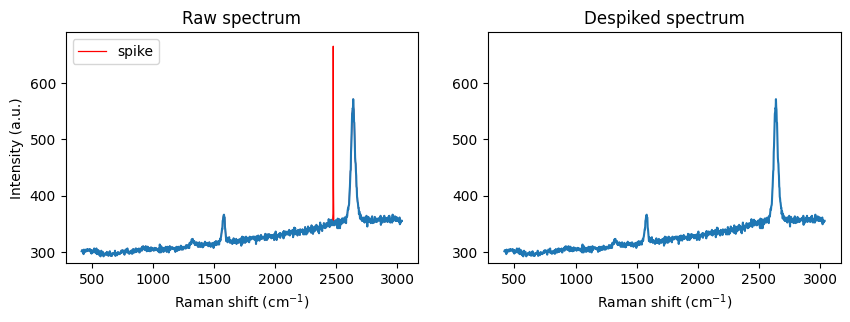

In [8]:
intensity_despiked = spike_removal(intensity, 
                                     width_threshold = 3, 
                                     prominence_threshold = 20, 
                                     moving_average_window=10, 
                                     width_param_rel=0.8, 
                                     interp_type='linear')

fig, ax = plt.subplots(1, 2, figsize = (2*5,3))
ax[0].plot(ramanshift, intensity, label = 'spike', color ='red', linewidth = 0.9)
ax[0].plot(ramanshift, intensity_despiked)
ax[1].plot(ramanshift, intensity_despiked)
ax[0].set_title('Raw spectrum')
ax[1].set_title('Despiked spectrum')
ax[0].legend()
ax[0].set_xlabel('Raman shift (cm$^{-1}$)')
ax[1].set_xlabel('Raman shift (cm$^{-1}$)')
ax[0].set_ylabel('Intensity (a.u.)')
ax[0].set_ylim(280,690)
ax[1].set_ylim(280,690)
plt.savefig('example spike removal.jpg', format='jpg', dpi=600, bbox_inches='tight')
plt.show()


This provides an easy function to look for and replace all spikes in your Raman hyperspectral data. 

I hoped you enjoyed this tutorial. Feel free to drop any questions or share your own Raman data challenges with me — I’d love to hear how this algorithm helps in your projects!

If you found this useful, please, remember to cite the original work  (https://doi.org/10.1016/j.aca.2024.342312), that would help me a lot! :)